In [1]:
from IPython.display import Image
import pandas as pd
%matplotlib inline
from sklearn import preprocessing
import SchemDraw
import SchemDraw.elements as e
import pandapower as pp
import pandapower.shortcircuit as sc
import numpy as np
import pvlib
from sklearn.cluster import KMeans

<font size="6" color='red'>Diagram of the Village</font>

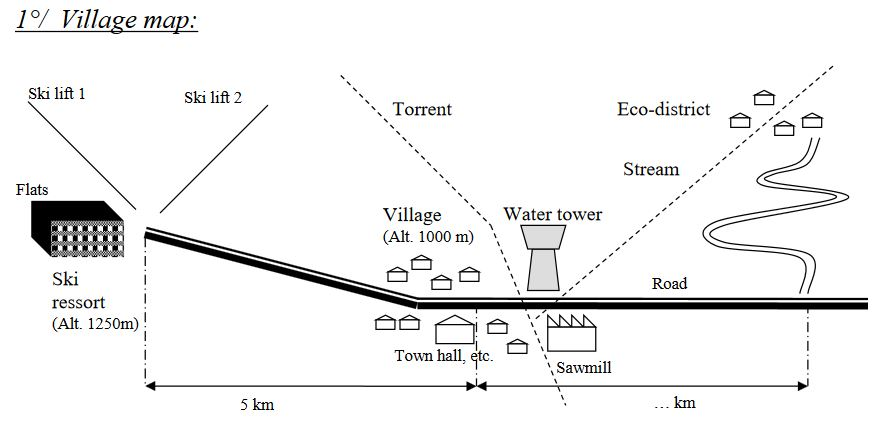

In [2]:
Image(filename='design_village.jpg') 

<font size="6" color='red'>General Parameters</font>

<font size="5" color='blue'>Geographical Data</font>

In [3]:
#data from the zone
latitude, longitude, name, altitude, timezone = (45.1996958, 5.5609121, 'Autrans', 1213, ' UTC+01:00')

<font size="5" color='blue'>Period to be analyzed</font>

For the analysis of the current project a 1 year period from 1st January 0:00 to 31 December 11 p.m of 2010 will be considered with data from each hour of the period

In [4]:
rng = pd.date_range(start="1/1/2010", end="2010-12-31 23:00:00", freq="H")
#rng = rng.tz_localize(timezone)

<font size="5" color='blue'>Lines</font>

In [5]:
#line values

overhead_line = {
    "lenght(km)": 8,
    "rated voltage(kV)": 20,
    "cross section(mm2)": 150,
    "short cirucuit power available: at substation(kV),(MVA)":((63,20),500)
}

ski_resort_line = {
    "lenght(km)": 5
}

<font size="5" color='blue'>Power consumption per unit</font>

In [6]:
#power consumption per unit

power = {
    "ski-resort":{
        "lifts(kW)": 75,
        "# of lifts": 2,
        "subscribers(kVA)":3,
        "# of subscribers": 15 
    },
    
    "village":{
        "subscribers(1)(kVA)": 6,
        "# of subscribers(1)": 180,
        "subscribers(2)(kVA)": 9,
        "# of subscribers(2)": 250,
        "subscribers(3)(kVA)": 12,
        "# of subscribers(3)": 100,
        "lighting and tower(kVA)": 36,
        "sawmill(kVA)": 36
    },
    
    "eco-distrcit":{
        "subscribers(1)(kVA)": 6,
        "# of subscribers(1)": 5,
        "subscribers(2)(kVA)": 9,
        "# of subscribers(2)": 12,
        "subscribers(3)(kVA)": 3,
        "# of subscribers(3)": 12
    }
}

<font size="5" color='blue'>Power factor per unit</font>

In [7]:
#power factor per unit

pf = {
    "ski-resort":{
        "lifts(kW)": .8,
        "subscribers(kVA)":.8,
    },
    
    "village":{
        "subscribers(1)(kVA)": .8,
        "subscribers(2)(kVA)": .8,
        "subscribers(3)(kVA)": .8,
        "lighting and tower(kVA)": .8,
        "sawmill(kVA)": .8
    },
    
    "eco-distrcit":{
        "subscribers(1)(kVA)": .8,
        "subscribers(2)(kVA)": .8,
        "subscribers(3)(kVA)": .8
    }
}

<font size="6" color='red'>Tempreature of the Village</font>

The outdoor temperature curve of the village can be measured by a small weather station.
The temperature curve is given in ° C for the period to be analyzed

<font size="5" color='brown'>Data</font>

In [8]:
#reading of temperature data from files

temperature_village = pd.read_csv('data/Temperature_2010_1h.txt', sep=" ", header=None)
temperature_village.columns = ["Temperature(Cº)"]
temperature_village.set_index(rng,inplace=True)
temperature_village.head()

,Temperature(Cº)
2010-01-01 00:00:00,2.41726
2010-01-01 01:00:00,1.91726
2010-01-01 02:00:00,1.41726
2010-01-01 03:00:00,0.91726
2010-01-01 04:00:00,0.51726


<font size="5" color='orange'>Temperature Plotting</font>

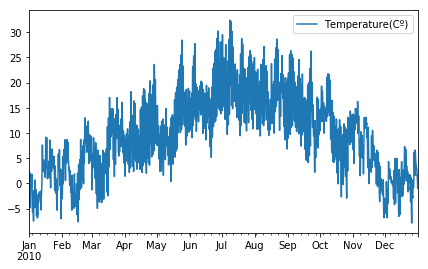

In [10]:
#plotting of temperature data

temperature_village.plot();

<font size="5" color='pink'>Temperature Data Analysis</font>

In [11]:
#Analysis of temperature data

temperature_village.describe()

,Temperature(Cº)
count,8760.000000
mean,9.472871
std,7.786131
min,-7.882740
25%,3.417260
50%,9.617260
75%,15.067260
max,32.417260


<font size="6" color='red'>Ski-Resort</font>

The ski-resort is located at 5km from the village

<font size="5" color='blue'>Power Calculation</font>

In [12]:
#computation of power consumption

ski_resort_df_data = {
    "lifts" : power["ski-resort"]["lifts(kW)"]*power["ski-resort"]["# of lifts"]/pf["ski-resort"]["lifts(kW)"],
    "subscribers" : power["ski-resort"]["subscribers(kVA)"]*power["ski-resort"]["# of subscribers"]/pf["ski-resort"]["subscribers(kVA)"]
}

ski_resort_df = pd.DataFrame(list(ski_resort_df_data.items()), columns=['Unit', 'Consumption(kVA)'])
ski_resort_df.loc['Total'] = pd.Series(ski_resort_df['Consumption(kVA)'].sum(), index = ['Consumption(kVA)'])

ski_resort_df

,Unit,Consumption(kVA)
0,lifts,187.50
1,subscribers,56.25
Total,NaN,243.75


<font size="5" color='brown'>Load Data</font>

In [13]:
#reading of load data from files

load_ski_station = pd.read_csv('data/P_ski station_2010_1h.txt', sep=" ", header=None)
load_ski_station.columns = ["Consumption(W)"]
load_ski_station.set_index(rng,inplace=True)
load_ski_station.head()

,Consumption(W)
2010-01-01 00:00:00,48155.106216
2010-01-01 01:00:00,54728.584096
2010-01-01 02:00:00,56447.570598
2010-01-01 03:00:00,57650.476372
2010-01-01 04:00:00,67961.215419


<font size="5" color='orange'>Ski-Resort Load</font>

The load of the ski-resort during the year has two clear different defined behaviors

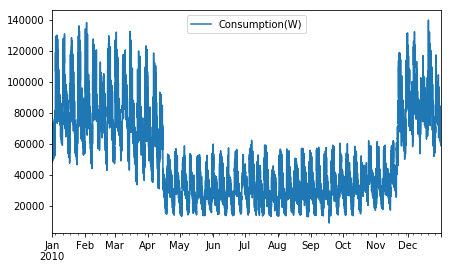

In [14]:
#plotting of load data

load_ski_station.plot();

<font size="5" color='pink'>Load Data Analysis</font>

In [14]:
#Analysis of temperature data

load_ski_station.describe()

,Consumption(W)
count,8760.000000
mean,51549.230303
std,28273.743989
min,8695.861233
25%,28736.262609
50%,43285.470631
75%,72454.855401
max,139776.037757


<font size="5" color='orange'>Ski-Resort Load vs Temperature</font>

The load of the ski-resort different behaviors can be explained by the behavior of temperature

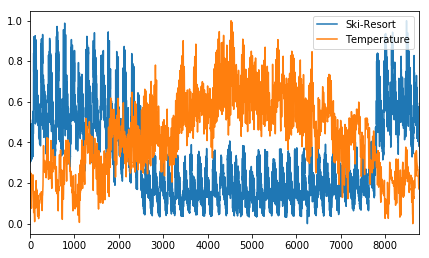

In [15]:
#comparison of load vs temperature normalized

ski_resort_temperature_merge = pd.merge(load_ski_station, temperature_village, left_index=True, right_index=True)
ski_resort_temperature_array = ski_resort_temperature_merge.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
ski_resort_temperature_scaled = min_max_scaler.fit_transform(ski_resort_temperature_array)
ski_resort_temperature_normalized = pd.DataFrame(ski_resort_temperature_scaled, columns=["Ski-Resort","Temperature"])
ski_resort_temperature_normalized.plot();

<font size="5" color='green'>Ski-Resort Clustering Periods</font>

In [79]:
km_ski_resort = KMeans(n_clusters=2, random_state=1)
km_ski_resort.fit(load_ski_station.values)
cluster_map_ski_resort = pd.DataFrame()
cluster_map_ski_resort['Consumption(W)'] = load_ski_station['Consumption(W)'].values
cluster_map_ski_resort['cluster'] = km.labels_
cluster_map_ski_resort.set_index(rng,inplace=True)

<font size="5" color='green'>Ski-Resort First Period</font>

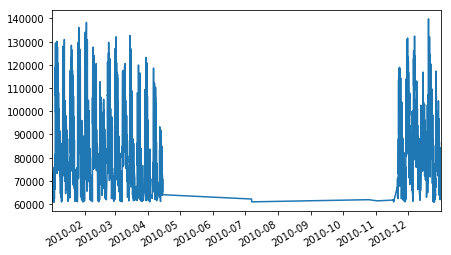

In [80]:
cluster_map_ski_resort[cluster_map_ski_resort.cluster == 0]['Consumption(W)'].plot();

<font size="5" color='brown'>Ski-Resort First Period Data Analysis</font>

In [81]:
cluster_map_ski_resort[cluster_map_ski_resort.cluster == 0]['Consumption(W)'].describe()

count      2832.000000
mean      86897.877808
std       17276.023908
min       60767.905066
25%       73493.467063
50%       84208.779726
75%       98473.364934
max      139776.037757
Name: Consumption(W), dtype: float64

<font size="5" color='green'>Ski-Resort Second Period</font>

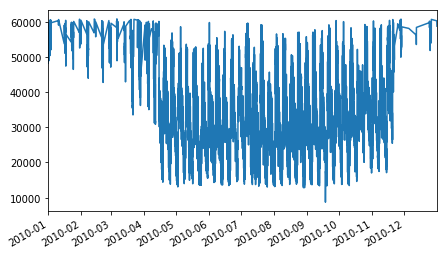

In [82]:
cluster_map_ski_resort[cluster_map_ski_resort.cluster == 1]['Consumption(W)'].plot();

<font size="5" color='brown'>Ski-Resort Second Period Data Analysis</font>

In [83]:
cluster_map_ski_resort[cluster_map_ski_resort.cluster == 1]['Consumption(W)'].describe()

count     5928.000000
mean     34662.022184
std      12511.831250
min       8695.861233
25%      24403.066002
50%      33840.703460
75%      43945.344957
max      60763.865592
Name: Consumption(W), dtype: float64

<font size="6" color='red'>Village</font>

The village is the main part of the analysis and is the contact to the grid.

<font size="5" color='blue'>Power Calculation</font>

In [85]:
village_df_data = {
    "subscribers(1)" : power["village"]["subscribers(1)(kVA)"]*power["village"]["# of subscribers(1)"]/pf["village"]["subscribers(1)(kVA)"],
    "subscribers(2)" : power["village"]["subscribers(2)(kVA)"]*power["village"]["# of subscribers(2)"]/pf["village"]["subscribers(2)(kVA)"],
    "subscribers(3)" : power["village"]["subscribers(3)(kVA)"]*power["village"]["# of subscribers(3)"]/pf["village"]["subscribers(3)(kVA)"],
    "lighting and tower" : power["village"]["lighting and tower(kVA)"]/pf["village"]["lighting and tower(kVA)"],
    "sawmill" : power["village"]["sawmill(kVA)"]/pf["village"]["sawmill(kVA)"]
}

village_df = pd.DataFrame(list(village_df_data.items()), columns=['Unit', 'Consumption(kVA)'])
village_df.loc['Total'] = pd.Series(village_df['Consumption(kVA)'].sum(), index = ['Consumption(kVA)'])

village_df

,Unit,Consumption(kVA)
0,subscribers(1),1350.0
1,subscribers(2),2812.5
2,subscribers(3),1500.0
3,lighting and tower,45.0
4,sawmill,45.0
Total,NaN,5752.5


<font size="5" color='brown'>Load Data</font>

In [120]:
load_village = pd.read_csv('data/P_village_2010_1h.txt', sep=" ", header=None)
load_village.columns = ["Consumption(W)"]
load_village.set_index(rng,inplace=True)
load_village.head()

,Consumption(W)
2010-01-01 00:00:00,9.405309e+05
2010-01-01 01:00:00,1.142462e+06
2010-01-01 02:00:00,1.030934e+06
2010-01-01 03:00:00,9.945415e+05
2010-01-01 04:00:00,8.827031e+05


<font size="5" color='orange'>Village Load</font>

The load of the village during the year has three clear different defined behaviors

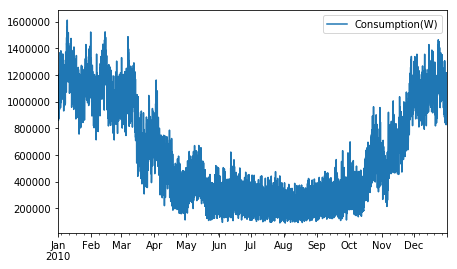

In [121]:
load_village.plot();

<font size="5" color='pink'>Village Load Data Analysis</font>

In [88]:
load_village.describe()

,Consumption(W)
count,8.760000e+03
mean,5.791802e+05
std,3.818494e+05
min,8.969528e+04
25%,2.361388e+05
50%,4.392702e+05
75%,9.601394e+05
max,1.610646e+06


<font size="5" color='orange'>Village Load vs Temperature</font>

The load of the village different behaviors can be explained by the behavior of temperature

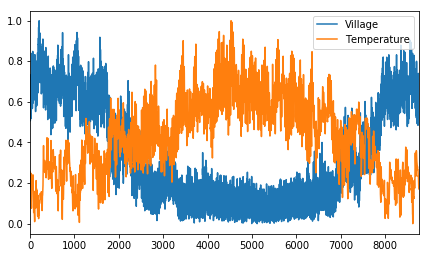

In [89]:
#comparison of load vs temperature normalized

village_temperature_merge = pd.merge(load_village, temperature_village, left_index=True, right_index=True)
village_temperature_array = village_temperature_merge.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
village_temperature_scaled = min_max_scaler.fit_transform(village_temperature_array)
village_temperature_normalized = pd.DataFrame(village_temperature_scaled, columns=["Village","Temperature"])
village_temperature_normalized.plot()

<font size="5" color='green'>Village Clustering Periods</font>

In [104]:
km_village = KMeans(n_clusters=3, random_state=2)
km_village.fit(load_village.values)
cluster_map_village = pd.DataFrame()
cluster_map_village['Consumption(W)'] = load_village['Consumption(W)'].values
cluster_map_village['cluster'] = km.labels_
cluster_map_village.set_index(rng,inplace=True)

<font size="5" color='green'>Village First Period</font>

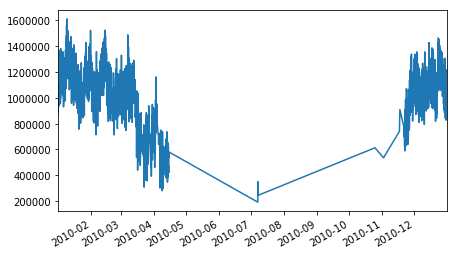

In [105]:
cluster_map_village[cluster_map_village.cluster == 0]['Consumption(W)'].plot();

<font size="5" color='brown'>Village First Period Data Analysis</font>

In [106]:
cluster_map_village[cluster_map_village.cluster == 0]['Consumption(W)'].describe()

count    2.832000e+03
mean     1.006837e+06
std      2.290464e+05
min      1.917057e+05
25%      9.041467e+05
50%      1.050927e+06
75%      1.163703e+06
max      1.610646e+06
Name: Consumption(W), dtype: float64

<font size="5" color='green'>Village Second Period</font>

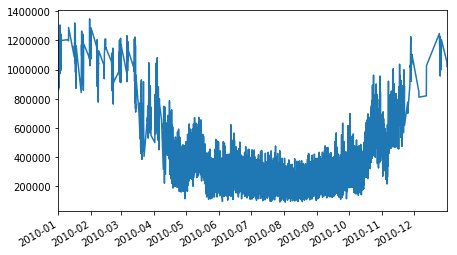

In [101]:
cluster_map_village[cluster_map_village.cluster == 1]['Consumption(W)'].plot();

<font size="5" color='brown'>Village Second Period Data Analysis</font>

In [92]:
cluster_map_village[cluster_map_village.cluster == 1]['Consumption(W)'].describe()

count    2.832000e+03
mean     1.006837e+06
std      2.290464e+05
min      1.917057e+05
25%      9.041467e+05
50%      1.050927e+06
75%      1.163703e+06
max      1.610646e+06
Name: Consumption(W), dtype: float64

<font size="6" color='red'>Diagram of the system</font>

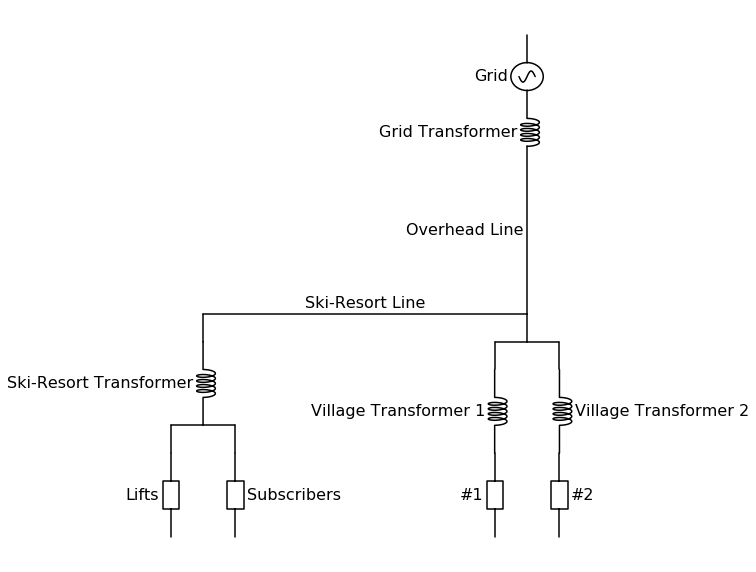

In [31]:
d = SchemDraw.Drawing()

#overhead line elements
V1 = d.add(e.SOURCE_SIN, d='down', label='Grid')
d.add(e.INDUCTOR2, label='Grid Transformer', l=1)
d.add(e.LINE, label="Overhead Line", l=6)

d.push() #save point 1 to return

#village elements
d.add(e.LINE, d='down', l=1)
d.push() #save point 2 to return
d.add(e.LINE, d='left', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.INDUCTOR2, label='Village Transformer 1', l=3)
d.add(e.RBOX, label='#1')
d.pop() #return to the point 2
d.add(e.LINE, d='right', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.INDUCTOR2, botlabel='Village Transformer 2', l=3)
d.add(e.RBOX, botlabel='#2')



d.pop() #return to the point 1

#ski resort elements
d.add(e.LINE, d='left', label="Ski-Resort Line", l=10)
d.add(e.LINE, d='down', l=1)
d.add(e.INDUCTOR2, label='Ski-Resort Transformer', l=3)
d.push() #save point 4 to return
d.add(e.LINE, d='left', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.RBOX, label='Lifts')
d.pop() #return to the point 4
d.add(e.LINE, d='right', l=1)
d.add(e.LINE, d='down', l=1)
d.add(e.RBOX, botlabel='Subscribers')


d.draw()

d.save('line_diagram.eps')

<font size="6" color='red'>Simulation of the Network</font>

In [32]:
net = pp.create_empty_network(name="village")

## elements(overhead line)
#buses
bus_1 = pp.create_bus(net, vn_kv=63, name="Bus_1")
bus_2 = pp.create_bus(net, vn_kv=20, name="Bus_2")
bus_3 = pp.create_bus(net, vn_kv=20, name="Bus_3")
#grid
pp.create_ext_grid(net, bus=bus_1, vm_pu=1.0, name="Grid Connection")
#transformer
pp.create_transformer(net, hv_bus=bus_1, lv_bus=bus_2, std_type="25 MVA 110/20 kV", name="Transformer Grid")
#line
pp.create_line(net, from_bus=bus_2, to_bus=bus_3, length_km=overhead_line["lenght(km)"], std_type="NA2XS2Y 1x150 RM/25 12/20 kV", name="Overhead line")

## elements(ski resort)
#buses
bus_4 = pp.create_bus(net, vn_kv=20, name="Bus_4")
bus_5 = pp.create_bus(net, vn_kv=20, name="Bus_5")
#line
pp.create_line(net, from_bus=bus_3, to_bus=bus_4, length_km=ski_resort_line["lenght(km)"], std_type="NA2XS2Y 1x150 RM/25 12/20 kV", name="Overhead line")
#transformer
#pp.create_transformer(net, hv_bus=bus_4, lv_bus=bus_5, std_type="", name="Transformer Ski-Resort")
#loads
pp.create_load(net, bus=bus_5, p_mw=0.15, q_mvar=0, name="Lifts")
pp.create_load(net, bus=bus_5, p_mw=0.045, q_mvar=0, name="Susbcribers")

#loads at the ski resort
#pp.create_load(net, bus=bus_7, p_mw=0.100, q_mvar=0.05, name="Load_1")
#pp.create_load(net, bus=bus_8, p_mw=0.100, q_mvar=0.05, name="Load_2")

#loads at the village

1

<font size="6" color='red'>Economic Analysis</font>

In [33]:
interest_rate = .08
years = 20
np.pv(interest_rate, years, 100)

-981.8147407449294

<font size="6" color='red'>Eco-District</font>

The village is the main part of the analysis and is the contact to the grid.

<font size="5" color='blue'>Power Calculation</font>

In [108]:
eco_district_df_data = {
    "subscribers(1)" : power["eco-distrcit"]["subscribers(1)(kVA)"]*power["village"]["# of subscribers(1)"]/pf["eco-distrcit"]["subscribers(1)(kVA)"],
    "subscribers(2)" : power["eco-distrcit"]["subscribers(2)(kVA)"]*power["village"]["# of subscribers(2)"]/pf["eco-distrcit"]["subscribers(2)(kVA)"],
    "subscribers(3)" : power["eco-distrcit"]["subscribers(3)(kVA)"]*power["village"]["# of subscribers(3)"]/pf["eco-distrcit"]["subscribers(3)(kVA)"]
}

eco_district_df = pd.DataFrame(list(eco_district_df_data.items()), columns=['Unit', 'Consumption(kVA)'])
eco_district_df.loc['Total'] = pd.Series(eco_district_df['Consumption(kVA)'].sum(), index = ['Consumption(kVA)'])

eco_district_df

,Unit,Consumption(kVA)
0,subscribers(1),1350.0
1,subscribers(2),2812.5
2,subscribers(3),375.0
Total,NaN,4537.5


<font size="5" color='brown'>Load Data</font>

In [122]:
load_eco_district = pd.read_csv('data/P_ecodistrict_2010_1h.txt', sep=" ", header=None)
load_eco_district.columns = ["Consumption(W)"]
load_eco_district.set_index(rng,inplace=True)
load_eco_district.head()

,Consumption(W)
2010-01-01 00:00:00,34297.910448
2010-01-01 01:00:00,44925.218326
2010-01-01 02:00:00,38253.186827
2010-01-01 03:00:00,37285.680931
2010-01-01 04:00:00,31724.993885


<font size="5" color='orange'>Eco-District Load</font>

The load of the eco-district during the year has three clear different defined behaviors

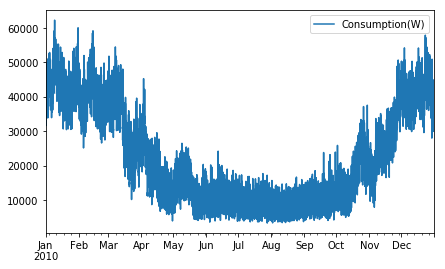

In [123]:
load_eco_district.plot();

<font size="5" color='pink'>Eco-District Load Data Analysis</font>

In [112]:
load_eco_district.describe()

,Consumption(W)
count,8760.000000
mean,21768.853197
std,14411.781505
min,3317.476818
25%,8846.556431
50%,16511.138745
75%,35901.399294
max,62234.142712


<font size="5" color='orange'>Eco-District Load vs Temperature</font>

The load of the eco-district different behaviors can be explained by the behavior of temperature

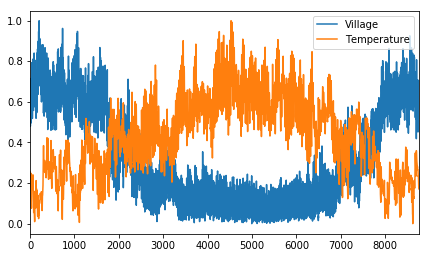

In [113]:
#comparison of load vs temperature normalized

eco_district_temperature_merge = pd.merge(load_eco_district, temperature_village, left_index=True, right_index=True)
eco_district_temperature_array = eco_district_temperature_merge.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
eco_district_temperature_scaled = min_max_scaler.fit_transform(eco_district_temperature_array)
eco_district_temperature_normalized = pd.DataFrame(eco_district_temperature_scaled, columns=["Village","Temperature"])
eco_district_temperature_normalized.plot()

<font size="5" color='green'>Eco-District Clustering Periods</font>

In [114]:
km_eco_district = KMeans(n_clusters=3, random_state=2)
km_eco_district.fit(load_eco_district.values)
cluster_map_eco_district = pd.DataFrame()
cluster_map_eco_district['Consumption(W)'] = load_eco_district['Consumption(W)'].values
cluster_map_eco_district['cluster'] = km.labels_
cluster_map_eco_district.set_index(rng,inplace=True)

<font size="5" color='green'>Eco-District First Period</font>

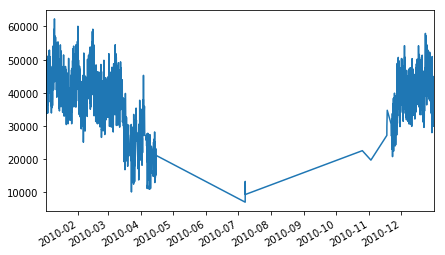

In [115]:
cluster_map_eco_district[cluster_map_eco_district.cluster == 0]['Consumption(W)'].plot();

<font size="5" color='brown'>Eco-District First Period Data Analysis</font>

In [106]:
cluster_map_village[cluster_map_village.cluster == 0]['Consumption(W)'].describe()

count    2.832000e+03
mean     1.006837e+06
std      2.290464e+05
min      1.917057e+05
25%      9.041467e+05
50%      1.050927e+06
75%      1.163703e+06
max      1.610646e+06
Name: Consumption(W), dtype: float64

<font size="5" color='green'>Eco-District Second Period</font>

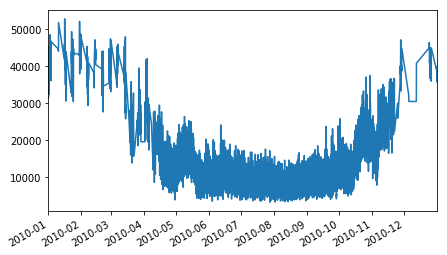

In [118]:
cluster_map_eco_district[cluster_map_eco_district.cluster == 1]['Consumption(W)'].plot();

<font size="5" color='brown'>Eco-District Second Period Data Analysis</font>

In [119]:
cluster_map_village[cluster_map_village.cluster == 1]['Consumption(W)'].describe()

count    5.928000e+03
mean     3.748746e+05
std      2.475581e+05
min      8.969528e+04
25%      1.986147e+05
50%      2.879127e+05
75%      4.671521e+05
max      1.347277e+06
Name: Consumption(W), dtype: float64

<font size="6" color='yellow'>PV production</font>

<font size="5" color='blue'>Production Calculation</font>

In [125]:
# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

#temperature
temp_series = temperature_village.squeeze()
#wind speed
wind_list = [0] * 8760
wind_df = pd.DataFrame(wind_list)
wind_df.columns = ["Wind Speed"]
wind_df.set_index(rng,inplace=True)
wind_series = wind_df.squeeze()

#calculations
system = {'module': module, 'inverter': inverter, 'surface_azimuth': 180}
times = rng
system['surface_tilt'] = latitude
solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(times)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
                           dni_extra=dni_extra, altitude=altitude)
aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
                           solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
                                                       system['surface_azimuth'],
                                                       solpos['apparent_zenith'],
                                                       solpos['azimuth'],
                                                       cs['dni'], cs['ghi'], cs['dhi'],
                                                       dni_extra=dni_extra,
                                                       model='haydavies')
temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
                                        wind_series, temp_series)
effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
total_irrad['poa_direct'], total_irrad['poa_diffuse'],
       am_abs, aoi, module)
dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
annual_energy = ac.sum()

#dataframe
production = pd.DataFrame({'list':ac.values})
production.columns = ["Production(W)"]
production.set_index(rng,inplace=True)
production.head()

,Production(W)
2010-01-01 00:00:00,-0.02
2010-01-01 01:00:00,-0.02
2010-01-01 02:00:00,-0.02
2010-01-01 03:00:00,-0.02
2010-01-01 04:00:00,-0.02


In [126]:
production['Production(W)'].sum()

469470.4794933579

<font size="5" color='orange'>Production per year</font>

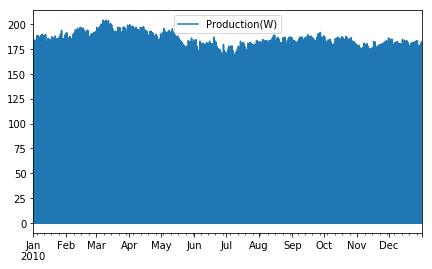

In [127]:
production.plot();

<font size="5" color='orange'>Production per day</font>

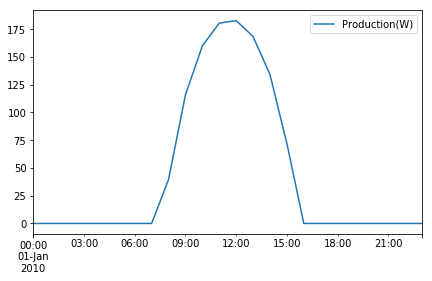

In [128]:
production["2010-01-01":"2010-01-01"].plot()

In [130]:
import os
from omegalpes.general.time import TimeUnit
#from omegalpes.general.utils.input_data import select_csv_file_between_dates
from omegalpes.energy.units.consumption_units import FixedConsumptionUnit, VariableConsumptionUnit
from omegalpes.energy.units.production_units import FixedProductionUnit, VariableProductionUnit
from omegalpes.energy.units.storage_units import StorageUnit
from omegalpes.energy.energy_types import elec
from omegalpes.energy.energy_nodes import EnergyNode
from omegalpes.actor.operator_actors.consumer_producer_actors import Producer, Prosumer
from omegalpes.general.optimisation.model import OptimisationModel
from pulp import LpStatus, PULP_CBC_CMD, GLPK_CMD, COIN_CMD, GUROBI_CMD, GUROBI

work_path = os.getcwd()

time = TimeUnit(periods=24, dt=1, start='01/01/2010 00:00')

load_eco_district_values = load_eco_district['Consumption(W)'].values.tolist()
production_values = production['Production(W)'].values.tolist()
number_of_pv = 300
production_values_new = [i * number_of_pv for i in production_values]

eco_district_unit = FixedConsumptionUnit(time=time, name='eco_district_unit', p=load_eco_district_values[0:24], energy_type=elec)
pv = FixedProductionUnit(time=time, name='pv', p=production_values_new[0:24], energy_type=elec)

grid_production = VariableProductionUnit(time, 'grid_production', energy_type=elec, pmax=50000, e_max=10000000000)
grid_consumption = VariableConsumptionUnit(time, 'grid_consumption', energy_type=elec, e_max=1000000000)

node = EnergyNode(time=time, name='elec_node', energy_type=elec)
node.connect_units(eco_district_unit, pv, grid_consumption, grid_production)


prosumer = Prosumer(name='prosumer',
                        operated_consumption_unit_list=[eco_district_unit],
                        operated_production_unit_list=[pv])
prosumer.maximize_selfconsumption_rate(time=time)
grid_production.minimize_production()

#Producer = Producer(name='Producer', operated_unit_list=[grid_production])

model = OptimisationModel(time=time, name='mountain_village')
model.add_nodes_and_actors(node, prosumer) 

model.writeLP(work_path + r'\optim_models\mountain_village.lp')
model.solve_and_update(PULP_CBC_CMD(msg=1))

You are studying the period from 2010-01-01 00:00:00 to 2010-01-01 23:00:00
Creating the eco_district_unit.
Creating the pv.
Creating the grid_production.
Creating the grid_consumption.
Creating the elec_node.
Creating the prosumer.
pv_p[t]
eco_district_unit_p[t]


D:\Programs\Anaconda3\lib\site-packages\omegalpes\general\optimisation\model.py:460: UserWarning: The unit elec_node seems to have as parent Autrans which was not declared as parent.
  'parent.'.format(unit.name, parent_name))



--- Adding all variables to the model ---
Adding variable : eco_district_unit_p
Adding variable : eco_district_unit_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : grid_consumption_p
Adding variable : grid_consumption_e_tot
Adding variable : grid_consumption_u
Adding variable : grid_production_p
Adding variable : grid_production_e_tot
Adding variable : grid_production_u
Adding variable : prosumer_conso_prod_match
Adding variable : prosumer_conso_prod_match_abs
Adding variable : prosumer_conso_prod_match_pos
Adding variable : prosumer_conso_prod_match_neg
Adding variable : prosumer_is_conso_prod_match_pos
Adding variable : prosumer_selfconsumption_rate
Adding variable : prosumer_selfconsumption_rate_abs
Adding variable : prosumer_selfconsumption_rate_pos
Adding variable : prosumer_selfconsumption_rate_neg
Adding variable : prosumer_is_selfconsumption_rate_pos

--- Adding all objectives to the model ---
Adding objective : grid_production_min_production
Adding o

In [131]:
if LpStatus[model.status] == 'Optimal':
    print("the total consumption from Eco-Dsitrict is {} kWh".format(float(eco_district_unit.e_tot) / 1000))
    print("the total production from PV is {} kWh".format(float(pv.e_tot) / 1000))
    print("the total grid production is {} kWh".format(float(grid_production.e_tot) / 1000))
    print("the total grid consumption {} kWh".format(float(grid_consumption.e_tot) / 1000))    

the total consumption from Eco-Dsitrict is 920.03575 kWh
the total production from PV is 315.96246 kWh
the total grid production is 648.42789 kWh
the total grid consumption 44.354597 kWh


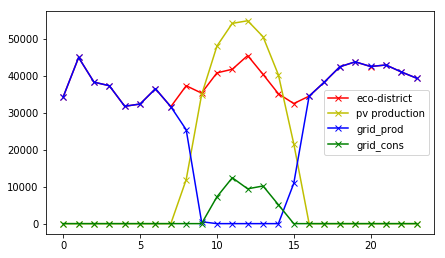

In [132]:
from omegalpes.general.utils.plots import plt, plot_quantity

fig1 = plt.figure(1)
ax1 = plt.axes()
plot_quantity(time, eco_district_unit.p, fig1, ax1, color='r', label='eco-district')
plot_quantity(time, pv.p, fig1, ax1, color='y', label='pv production')
plot_quantity(time, grid_production.p, fig1, ax1, color='b', label='grid_prod')
plot_quantity(time, grid_consumption.p, fig1, ax1, color='g', label='grid_cons')
ax1.legend()

In [151]:
storage = StorageUnit(time, name='storage', ef_is_e0=False)
#storage.minimize_capacity()

node = EnergyNode(time=time, name='elec_node', energy_type=elec)
node.connect_units(eco_district_unit, pv, storage, grid_consumption, grid_production)

prosumer = Prosumer(name='prosumer',
                        operated_consumption_unit_list=[eco_district_unit],
                        operated_production_unit_list=[pv])
prosumer.maximize_selfconsumption_rate(time=time)
grid_production.minimize_production()

model = OptimisationModel(time=time, name='mountain_village_2')
model.add_nodes_and_actors(node, prosumer) 

model.writeLP(work_path + r'\optim_models\mountain_village_2.lp')
model.solve_and_update(PULP_CBC_CMD(msg=1))

Creating the storage.
Creating the elec_node.
Creating the prosumer.
pv_p[t]
eco_district_unit_p[t]

--- Adding all variables to the model ---
Adding variable : eco_district_unit_p
Adding variable : eco_district_unit_e_tot
Adding variable : pv_p
Adding variable : pv_e_tot
Adding variable : storage_p
Adding variable : storage_e_tot
Adding variable : storage_u
Adding variable : storage_capacity
Adding variable : storage_e
Adding variable : storage_pc
Adding variable : storage_pd
Adding variable : storage_uc
Adding variable : storage_e_f
Adding variable : grid_consumption_p
Adding variable : grid_consumption_e_tot
Adding variable : grid_consumption_u
Adding variable : grid_production_p
Adding variable : grid_production_e_tot
Adding variable : grid_production_u
Adding variable : prosumer_conso_prod_match
Adding variable : prosumer_conso_prod_match_abs
Adding variable : prosumer_conso_prod_match_pos
Adding variable : prosumer_conso_prod_match_neg
Adding variable : prosumer_is_conso_prod_mat

In [152]:
if LpStatus[model.status] == 'Optimal':
    print("the total consumption from Eco-Dsitrict is {} kWh".format(float(eco_district_unit.e_tot) / 1000))
    print("the total production from PV is {} kWh".format(float(pv.e_tot) / 1000))
    print("the total grid production is {} kWh".format(float(grid_production.e_tot) / 1000))
    print("the total grid consumption is {} kWh".format(float(grid_consumption.e_tot) / 1000))
    print("The optimal storage capacity is {0} kWh".format(storage.capacity))

the total consumption from Eco-Dsitrict is 920.03575 kWh
the total production from PV is 315.96246 kWh
the total grid production is 504.07329 kWh
the total grid consumption is 0.0 kWh
The optimal storage capacity is 124501.06 kWh


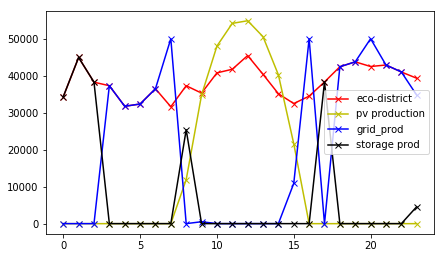

In [153]:
fig2 = plt.figure(2)
ax2 = plt.axes()
plot_quantity(time, eco_district_unit.p, fig2, ax2, color='r', label='eco-district')
plot_quantity(time, pv.p, fig2, ax2, color='y', label='pv production')
plot_quantity(time, grid_production.p, fig2, ax2, color='b', label='grid_prod')
#plot_quantity(time, grid_consumption.p, fig2, ax2, color='g', label='grid_cons')
plot_quantity(time, storage.pd, fig2, ax2, color='black', label='storage prod')
ax2.legend()